In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
import json
# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    Model
)
from gammapy.estimators import ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit
import import_dataset_helper

In [2]:
'''colors_case = ['darkorange', 'red', 'maroon', 'grey', 'grey']
fmts = ['^', 'o',  'x', 's']
color_overall_standard = 'green'
label = 'Correct Est. ($\mu$ +  $\sigma$)'
labelunder = "Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)"
labelover =  "Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)"
labelstandard = "No Nuisance Par. "'''

# standard and Nuisance
colors_case = ['green', 'red']
fmts = ['o', 'x']
labels = ["Standard", "With Nuisance Par."]
colors_e = ['purple' , 'blue', 'green', 'teal', 'crimson' , 'yellow']

#path_local_repo_saturn = '/home/saturn/caph/mppi045h/Nuisance_Asimov_Datasets'
#models = Models.read("1a-Source_models.yaml")
outputfolder = 'output/data_asimov_tests'


with open('1-amplitudes_where_sys_smaller.json', 'r') as fp:
    a_threshold  = json.load(fp)
print(a_threshold)

{'pointsource_center': '1e-12', 'gaussiansource_center': '1e-12', 'largegaussiansource_center': '1e-10'}


## Nuisance

In [3]:
def get_circ_mask(geom , radius ):
    center_coord = geom.center_skydir
    #radius = 2*u.deg
    skyregion = CircleSkyRegion(center=center_coord, radius = radius)
    map_mask= Map.from_geom(geom, 
                                data=geom.region_mask([skyregion], inside=True).data)
    return map_mask

In [4]:
def create_MapDataset(dataset):
    
    mapdatset = MapDataset(models=None, 
                           counts=None, 
                           exposure=dataset.exposure, 
                           background=dataset.background, 
                           psf=dataset.psf, 
                           edisp=dataset.edisp, 
                           mask_safe=dataset.mask_safe, 
                           mask_fit=dataset.mask_fit, 
                           gti=dataset.gti, 
                           meta_table=dataset.meta_table, 
                           name="basic")
    
    bkg_model = FoVBackgroundModel(dataset_name=mapdatset.name) 
    #bkg_model.parameters['norm'].value = dataset.background_model.parameters['norm'].value
    #bkg_model.parameters['tilt'].value = dataset.background_model.parameters['tilt'].value
    models = Models([dataset.models[0].copy()])
    models.append(bkg_model)
    mapdatset.models = models
    mapdatset.counts = dataset.counts
    mapdatset.background = dataset.npred_background()
    return mapdatset

def compute_residual(dataset, energy_edges ,  max_ = None, radius = 1.0*u.deg,  ):
    
    estimator = ExcessMapEstimator( correlation_radius=radius , 
                                       energy_edges=energy_edges) 
    result = estimator.run(dataset) 
    residual = result["sqrt_ts"]#.slice_by_idx(dict(energy=slice(e,e+1)))

    if max_ is None:
        vmax = np.nanmax(np.abs(residual.data))
    else:
        vmax = max_
    return residual

In [5]:
def plot_residuals(res, title, max_):
    data_zero = res#.slice_by_idx(dict(energy=slice(i_start,i_end)))
    if max_ is None:
        max_ = np.nanmax(np.abs(data_zero.data))
    axs = data_zero.plot_grid(add_cbar = 1,cmap = 'coolwarm', vmin = -max_, vmax = max_);
    axs = axs.flatten()
    #data_zero.data = np.nan_to_num(data_zero.data)
    mean = np.nanmean(data_zero, axis=2)
    mean = np.nanmean(mean, axis = 1)
    std = np.nanstd(data_zero, axis=2)
    std = np.nanstd(std, axis = 1)
    for i in range(len(mean)):
        axs.flatten()[i].text(10,35, f'{mean[i]:.2} $\pm$ {std[i]:.2}', fontsize = 12)
    plt.suptitle(title, 
                 fontsize = 14, y=1.01)
    return max_

from scipy.stats import ks_2samp

def get_data_to_plot(dataset,mocked ,type_, i_start, i_end):
    if type_ =='npred':
        data= dataset.npred() 
    
    if type_ =='counts':
        data= dataset.counts 
        
    data *= get_circ_mask(data.geom , 2*u.deg )
    data = data.slice_by_idx(dict(energy = slice(i_start, i_end)))
    data = data.data.flatten()
    data = [d for d in data if d != 0]    
        
    return data


def compute_ratio(dataset, mocked):
    if mocked is not None:
        npred= mocked.npred_background() 
    else:
        npred= dataset.npred_background() 
        
    sys = npred - dataset.background # in counts
    sys = np.abs(sys.data).sum(axis=2).sum(axis=1)
    stat = np.sqrt(dataset.background.data.sum(axis=2).sum(axis=1))
    return sys[i_start:i_end] /stat[i_start:i_end]

def compute_p_value(input_, recovered_ ):
    KS, p = ks_2samp(input_, recovered_, alternative='two-sided',)
    return p
def plot_bg_p_value_multiple (tupels, elist, type_,):
    fig, axs = plt.subplots(1, 1, figsize =(10, 3* 1) ,
                           sharex = True)
    #syss = [sys_a, sys_b, sys_c]
    for i,e in enumerate(xaxis[i_start:i_end]):
        ps, ps_under, ps_over, ps_standard, ratio = [], [],[],[],[]
        for j,tupel in enumerate(tupels):
            ax = axs
            dataset_fitting = tupel[0]
            mocked = tupel[1]
            dataset = mocked.dataset_N_sys
            mus = tupel[2]
            stds = tupel[3]
            dataset_under = tupel[4]
            dataset_over= tupel[5]
            dataset_standard = tupel[6]
            
            if type_ =='npred':
                i_ = i+i_start
                title = "Predicted Counts Accuracy"
                pos = -0
                input_ =  get_data_to_plot(dataset,    None,  'counts', i_, i_+1)

            recovered_ = get_data_to_plot(dataset_fitting, None, type_, i_, i_+1)
            p = compute_p_value(input_, recovered_)
            ps.append(p)
            ratio.append(compute_ratio(dataset ,mocked)[i])
            
            if dataset_under is not None:
                recovered_ = get_data_to_plot(dataset_under, None, type_, i_, i_+1)
                p = compute_p_value(input_, recovered_)
                ps_under.append(p)
            if dataset_over is not None:
                recovered_ = get_data_to_plot(dataset_over, None, type_, i_, i_+1)
                p = compute_p_value(input_, recovered_)
                ps_over.append(p)
            if dataset_standard is not None:
                recovered_ = get_data_to_plot(dataset_standard, None, type_, i_, i_+1)
                p = compute_p_value(input_, recovered_)
                ps_standard.append(p)
            else:
                ps_standard = [0]
            
        if i ==0:
            labels_ = labels
        else:
            labels_= ['', '']
        asymmetric_error_under = np.array(list(zip([np.std(ratio)-0.1] ,
                                                   [np.std(ratio)+0.1]))).T
        asymmetric_error_over = np.array(list(zip([np.std(ratio)+0.1] ,
                                                   [np.std(ratio)-0.1]))).T
        
        #xs = [np.mean(ratio) - 0.1,  np.mean(ratio), np.mean(ratio) + 0.1,  np.mean(ratio)]
        #ys = [np.mean(ps_under), np.mean(ps), np.mean(ps_over),np.mean(ps_standard)]
        #xerrs = [ asymmetric_error_under, np.std(ratio), asymmetric_error_over, np.std(ratio)]
        #yerrs = [np.std(ps_under), np.std(ps), np.std(ps_over), np.std(ps_standard) ]
        
        xs = [ np.mean(ratio) + 0.1,  np.mean(ratio)]
        ys = [ np.mean(ps),np.mean(ps_standard)]
        xerrs = [  asymmetric_error_over, np.std(ratio)]
        yerrs = [np.std(ps), np.std(ps_standard) ]
        
        for k in np.arange(len(xs)):
            markersize = 7 
            if k ==1:
                markersize = 10
            ax.errorbar(x= xs[k],y = ys[k] , yerr= yerrs[k] , 
                    xerr= xerrs[k], color = colors_case[k], ecolor = colors_e[i],
                    label =labels_[k] , marker = fmts[k],  markersize = markersize,)
        #ax.errorbar(x= xs[3],y = ys[3] , yerr= yerrs[3] , 
        #            xerr= xerrs[3], color = colors_e[i], ecolor = colors_e[i],
        #            label =labels[3] , marker = fnts[3],  markersize = 10,)
            
        ax.legend(loc = 'lower right')
        offset = 0.4
        if i==2:
            offset= 0.7
        ax.text(np.mean(ratio)-offset, 1.1, f"Energy: \n{e:.2}", color = colors_e[i])
    
    ax.set_title(title)
    ax.set_xlabel("Ratio Systematics / Statistics")
    ax.set_ylabel("P-Value")
    xlim = ax.get_xlim()
    ax.hlines(1, xlim[0], xlim[1], color ='grey')
    ax.hlines(0.95, xlim[0], xlim[1], color ='grey')
    ax.text(xlim[1]-0.2, pos, f"N= {len(tupels)}")
    ax.set_ylim(ax.get_ylim()[0], 1.2)
    return ps


## Load Single Amplitudes

In [6]:
def get_finished_rnds(amplitude):
    outputfile = '/OOutput'+str(amplitude.value)+'.json'

    with open(outputfolder+outputfile, 'r') as f:
        data = json.load(f)
    rnds = list(data.keys()) 
    rnd_started, rnd_finished = [], []
    for i in range(len(rnds)):
        try:
            data[str(rnds[i])]['result'] 
            rnd_finished.append(int(rnds[i]))
        except:
            None
    return rnd_finished

In [7]:
i_start,i_end = 6,10
elist = np.linspace(i_start,i_end, i_end-i_start )



0
1
2
3
4
5
6
7


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_4703/156823723.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two mino

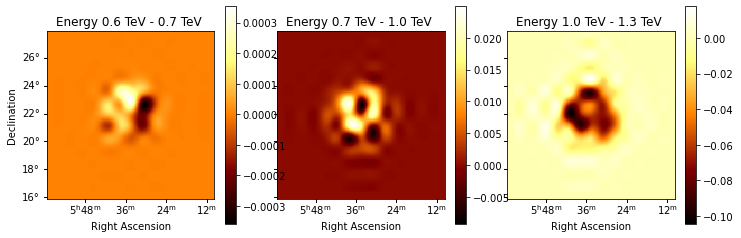

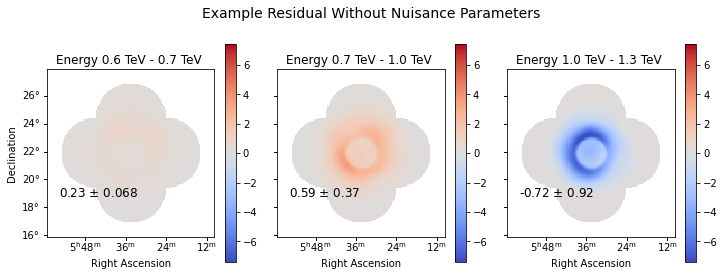

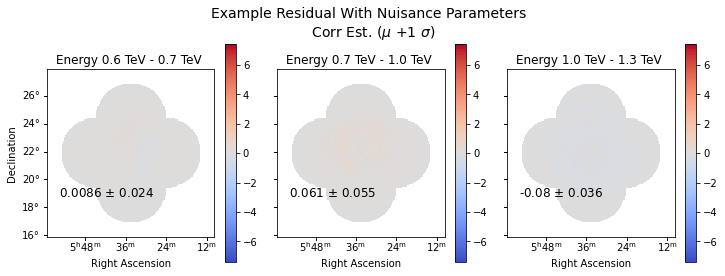

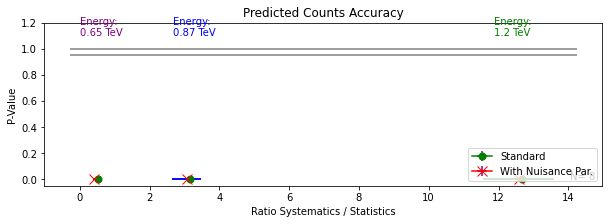

In [8]:
amplitude =  1e-9*u.Unit('cm-2 s-1 TeV-1')
rnds = get_finished_rnds(amplitude)
analysis_1e9 = import_dataset_helper.analysis('pointsource_center',amplitude,rnds, False)
kk = -1

xaxis = analysis_1e9.datasets_standard[1].geoms['geom'].axes[0].center
energy_edges = analysis_1e9.datasets_standard[kk].counts.geom.axes['energy'].edges[i_start:i_end]


analysis_1e9.datasets_corr[-1].N_map().slice_by_idx(dict(energy=slice(6,9))).plot_grid(add_cbar =1);

max_ = plot_residuals(compute_residual(create_MapDataset(analysis_1e9.datasets_standard[0]), energy_edges), 
                      "Example Residual Without Nuisance Parameters", None)

plot_residuals(compute_residual(create_MapDataset(analysis_1e9.datasets_corr[kk]), energy_edges), 
               "Example Residual With Nuisance Parameters \n Corr Est. ($\mu$ +1 $\sigma$)", max_)
i_end =9
tupels = [(analysis_1e9.datasets_corr[i], analysis_1e9.mocked_dataset_s[i], np.nan, np.nan,
           analysis_1e9.datasets_under[i],
           analysis_1e9.datasets_over[i], analysis_1e9.datasets_standard[i]) 
          for i in range(len(analysis_1e9.datasets_corr))]

plot_bg_p_value_multiple(tupels, elist, 'npred')

0
1
2
3
4
5
6
7
8
20
21
22
23
24
25
26
27
28
40
41
42
43
44
45
46
47
48
60
61
62
63
64
65
66
67
68
69
80
81
82
83
84
85
86
87
88
89


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_4703/156823723.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two mino

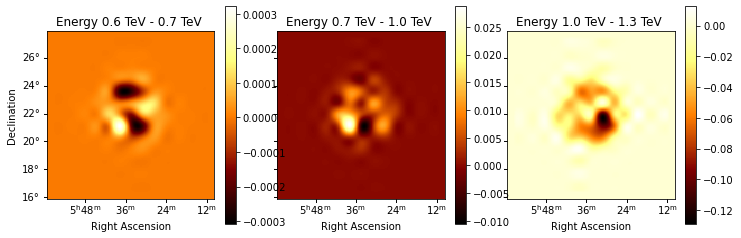

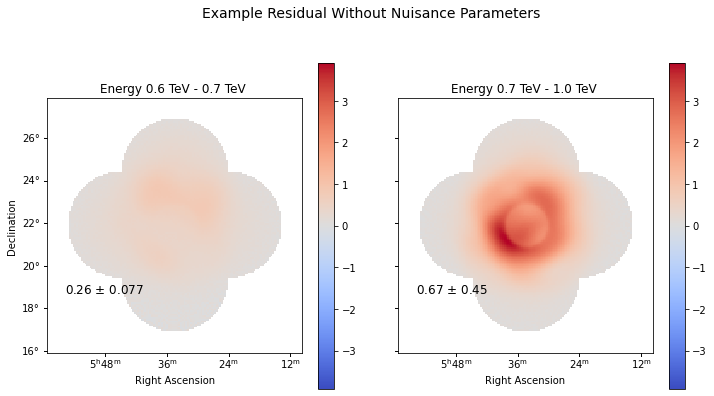

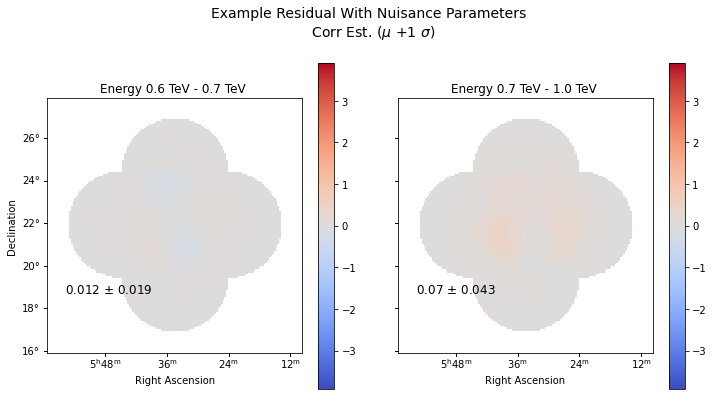

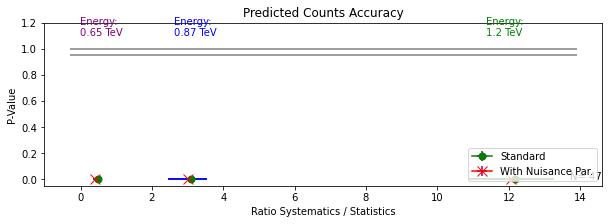

In [9]:
amplitude =  1e-10*u.Unit('cm-2 s-1 TeV-1')
rnds = get_finished_rnds(amplitude)
analysis_1e10 = import_dataset_helper.analysis('pointsource_center',amplitude,rnds, False)
kk = -1

xaxis = analysis_1e10.datasets_standard[1].geoms['geom'].axes[0].center
energy_edges = analysis_1e10.datasets_standard[kk].counts.geom.axes['energy'].edges[i_start:i_end]


analysis_1e10.datasets_corr[-1].N_map().slice_by_idx(dict(energy=slice(6,9))).plot_grid(add_cbar =1);

max_ = plot_residuals(compute_residual(create_MapDataset(analysis_1e10.datasets_standard[0]), energy_edges), 
                      "Example Residual Without Nuisance Parameters", None)

plot_residuals(compute_residual(create_MapDataset(analysis_1e10.datasets_corr[kk]), energy_edges), 
               "Example Residual With Nuisance Parameters \n Corr Est. ($\mu$ +1 $\sigma$)", max_)
i_end =9
tupels = [(analysis_1e10.datasets_corr[i], analysis_1e10.mocked_dataset_s[i], np.nan, np.nan,
           analysis_1e10.datasets_under[i],
           analysis_1e10.datasets_over[i], analysis_1e10.datasets_standard[i]) 
          for i in range(len(analysis_1e10.datasets_corr))]

plot_bg_p_value_multiple(tupels, elist, 'npred')

0
1
2
3
4
5
6
7
8
20
21
22
23
24
25
26
40
41
42
43
44
45
46
60
61
62
63
64
65
66
67
68
80
81
82
83
84
85
86
87
88
89


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_4703/156823723.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two mino

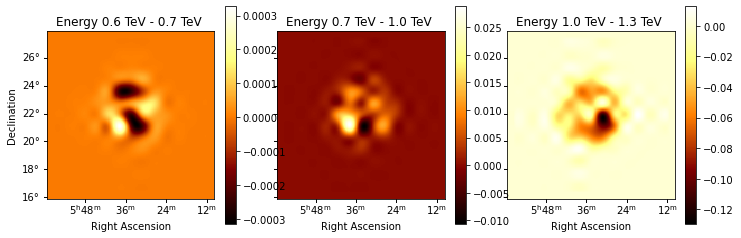

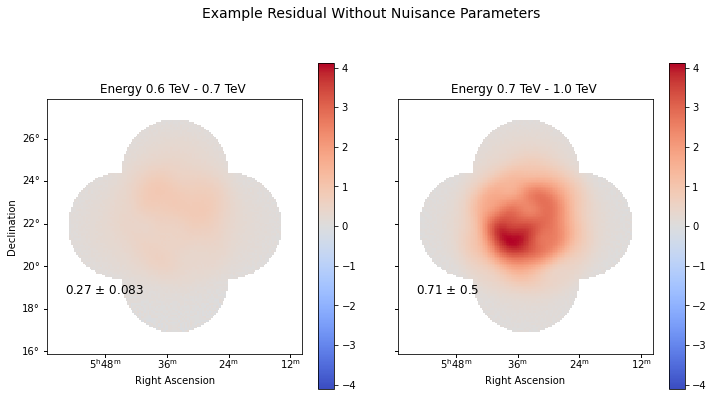

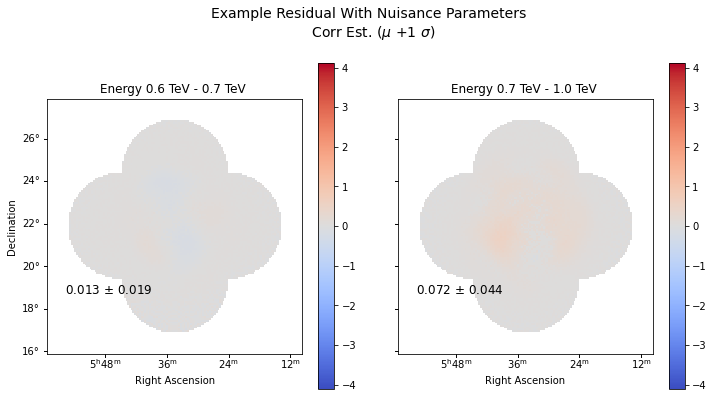

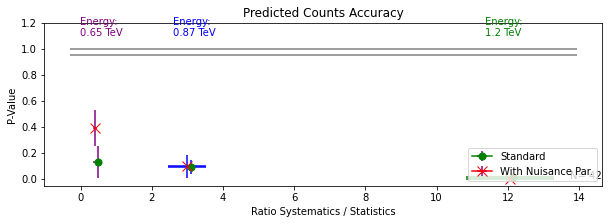

In [10]:
amplitude =  1e-11*u.Unit('cm-2 s-1 TeV-1')
rnds = get_finished_rnds(amplitude)
analysis_1e11 = import_dataset_helper.analysis('pointsource_center',amplitude,rnds, False)
kk = -1

xaxis = analysis_1e11.datasets_standard[1].geoms['geom'].axes[0].center
energy_edges = analysis_1e11.datasets_standard[kk].counts.geom.axes['energy'].edges[i_start:i_end]


analysis_1e11.datasets_corr[-1].N_map().slice_by_idx(dict(energy=slice(6,9))).plot_grid(add_cbar =1);

max_ = plot_residuals(compute_residual(create_MapDataset(analysis_1e11.datasets_standard[0]), energy_edges), 
                      "Example Residual Without Nuisance Parameters", None)

plot_residuals(compute_residual(create_MapDataset(analysis_1e11.datasets_corr[kk]), energy_edges), 
               "Example Residual With Nuisance Parameters \n Corr Est. ($\mu$ +1 $\sigma$)", max_)

i_end =9
tupels = [(analysis_1e11.datasets_corr[i], analysis_1e11.mocked_dataset_s[i], np.nan, np.nan,
           analysis_1e11.datasets_under[i],
           analysis_1e11.datasets_over[i], analysis_1e11.datasets_standard[i]) 
          for i in range(len(analysis_1e11.datasets_corr))]



plot_bg_p_value_multiple(tupels, elist, 'npred')

In [11]:
amplitude =  1e-12*u.Unit('cm-2 s-1 TeV-1')
rnds = get_finished_rnds(amplitude)
#rnds = [90,91]#,92,93,94,95,96,97,98,99]
analysis_1e12 = import_dataset_helper.analysis('pointsource_center',amplitude,rnds, False)
kk = -1

xaxis = analysis_1e12.datasets_standard[1].geoms['geom'].axes[0].center
energy_edges = analysis_1e12.datasets_standard[kk].counts.geom.axes['energy'].edges[i_start:i_end]


analysis_1e12.datasets_corr[-1].N_map().slice_by_idx(dict(energy=slice(6,9))).plot_grid(add_cbar =1);

max_ = plot_residuals(compute_residual(create_MapDataset(analysis_1e12.datasets_standard[0]), energy_edges), 
                      "Example Residual Without Nuisance Parameters", None)

plot_residuals(compute_residual(create_MapDataset(analysis_1e12.datasets_corr[kk]), energy_edges), 
               "Example Residual With Nuisance Parameters \n Corr Est. ($\mu$ +1 $\sigma$)", max_)

i_end =9
tupels = [(analysis_1e12.datasets_corr[i], analysis_1e12.mocked_dataset_s[i], np.nan, np.nan,
           analysis_1e12.datasets_under[i],
           analysis_1e12.datasets_over[i], analysis_1e12.datasets_standard[i]) 
          for i in range(len(analysis_1e12.datasets_corr))]



plot_bg_p_value_multiple(tupels, elist, 'npred')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
40


MemoryError: Unable to allocate 75.7 MiB for an array with shape (3150, 3150) and data type >f8

## Multiple Nice Plot Fit Quality

In [12]:
i_start = 6
i_end = 12

def compute_quality_value(dataset):
    input_ =  get_data_to_plot(dataset,    None,  'counts', i_start, i_end)
    recovered_ = get_data_to_plot(dataset, None,  'npred', i_start, i_end)
    p = compute_p_value(input_, recovered_)
    return p


def compute_quality_values(datasets):
    ps = []
    for dataset in datasets:
        p = compute_quality_value(dataset)
        ps.append(p)
    return ps

def plot_qualities(analysiss):
        fig, ax = plt.subplots(1,1, )#figsize =(10,10))
        ax = [ax]
        fmts = ['o', 'x']
        colors = ['green', 'red']
        labels = ['Standard', "With Nuisance Par."]
        for j, analysis in enumerate(analysiss):
            if j ==0:
                labels_= labels
            else:
                labels_ = ['', '']
            datasets_cases = (analysis.datasets_standard, analysis.datasets_corr)
            for i, datasets_case in enumerate(datasets_cases):
                # i = 0: standard, i=1: N
                ps= compute_quality_values(datasets_case)
                am = analysis.amplitude.value * 1e12
                ax[0].errorbar(am, np.mean(ps),
                           yerr = [np.std(ps)], fmt =fmts[i], color= colors[i],
                              label = labels_[i])
        ax[0].set_xscale('log')
        ax[0].set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
        ax[0].set_ylabel("P-Value of Model Prediction")
        ax[0].hlines(1, xlim_all[0], xlim_all[1] ,color = "grey")
        ax[0].hlines(0.95, xlim_all[0], xlim_all[1] ,color = "grey")
        ax[0].legend()
        ax[0].set_title("Fit Quality (p-value) - Point Source")
        return fig, ax






In [13]:

xlim_all = (0.005623413251903491, 1000)

analysiss = [analysis_1e12, analysis_1e11, analysis_1e10, analysis_1e9]
fig , ax1= plot_qualities(analysiss)
ylim = ax1.get_ylim()
ax1.fill_betweenx( y = ylim ,
                 x1 =ax1.get_xlim()[0] , x2=  float(a_threshold['pointsource_center'] )*1e12
                 , color = 'darkmagenta', alpha = 0.2, hatch = '/')
fig.savefig("plots/4_Point_source_pvalue.png")
fig.savefig("plots/4_Point_source_pvalue.pdf")

NameError: name 'analysis_1e12' is not defined

## Residuals

In [ ]:
def plot_mulitple_nui_distribution(datasets,  mus, stds):
    ilength = i_end - i_start
    ii = ilength //3 + 1
    fig, axs = plt.subplots(ii,3
                            , figsize =(20,7 * ii) )
    alpha = 1 / len(datasets)
    for i,e in enumerate(xaxis[i_start:i_end]):
        ax = axs.flatten()[i]
        mu, sigma_ = mus[i+i_start], stds[i+i_start]  # mean and standard deviation
        counts = []
        
        for j,dataset in enumerate(datasets):
            nui_values_co = dataset.N_parameters.value
            nui_values_co = np.array(nui_values_co) *100
            s = nui_values_co[i*amount_free_par : (i+1)* amount_free_par]
            range = (mu- 4 *  sigma_  , mu + 4*  sigma_  )
            
            nbins = range[1]- range[0]
            nbins = int(np.round(nbins)) * 10
            nbins = 50
            if j == 0:
                count, bins = np.histogram(s, bins = nbins, range = range)
                bin_center = (bins[1:] + bins[:-1] )/ 2        
                ax.plot(bin_center,count, alpha = alpha/1, color = 'cornflowerblue')
            else:
                count, bins = np.histogram(s, bins = bins)
                bin_center = (bins[1:] + bins[:-1] )/ 2        
                ax.plot(bin_center,count, alpha = alpha/1, color = 'cornflowerblue')
                
            counts.append(count)
            x = np.linspace(range[0],range[1], 100)
        ax.plot(x,  np.diff(bins)[0] *  sum(count)/ np.sqrt(2 * np.pi * sigma_**2)*
                                np.exp( - (x - mu)**2 / (2 * sigma_**2) ),
                          linewidth=2, color='midnightblue',alpha = 1,
               label = f"Gaus($\mu$ ={0.}, $\sigma$ = {sigma_:.2})")
            
        counts = np.array(counts)        
        ax.set_title(f'Energy: {xaxis[i+i_start].value:.2} TeV')
        #bin_center = (bins[1:] + bins[:-1] )/ 2        
        ax.errorbar( x = bin_center,  y = counts.mean(axis= 0), yerr = counts.std(axis=0),
                   label = f'Mean of {len(counts)} Draws')
        ylim = [0,np.max(counts)]
        underepsi = (np.abs(mu)+ 0.5 * sigma_)
        epsi = (np.abs(mu)+ 1 * sigma_)
        overepsi = (np.abs(mu)+ 2 * sigma_)
        epsis = [underepsi,epsi, overepsi]
        labels= [f"Exp. {underepsi :.3}%  ($\mu + 0.5 \cdot \sigma$) ",
                f"Exp. {epsi :.3}%  ($\mu +  \sigma$) ",
                f"Exp. {overepsi :.3}%  ($\mu + 2 \cdot \sigma$) "]
        colors = ['darkorange', 'red', 'maroon']
        
        markertypes = ['o', 'x', 's']
        for i in np.arange(len(epsis)):
            ax.vlines(0 +epsis[i], ylim[0], ylim[1]  ,alpha = 1,color = colors[i],linewidth =2,
                 label = labels[i])
            ax.vlines(0 -epsis[i], ylim[0], ylim[1] ,alpha = 1,color = colors[i],linewidth =2,
                 label = '')
            ax.scatter(0+epsis[i], ylim[1], color = colors[i], marker= markertypes[i],s = 40)
            ax.scatter(0-epsis[i], ylim[1], color = colors[i], marker= markertypes[i],s = 40)
        
        #ax.set_ylim(-0.5, ylim[1])
        ax.legend()
        ax.set_xlabel("Mocked Systematic [% of BG]")
    plt.suptitle(f"Multiple Draws of Systematic based on Gaus (Crab) [% of BG]",
                     fontsize = 14)
    return fig

def create_sig_histo(res):
    hist,binedges = np.histogram(res, bins = nbins,range = binrange )
    return hist, binedges

def plot_histo(hist, binedges, color, ax):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    
    return ax

nbins = 40 
binrange= (-10, 10)
energy_edges =analysis_1e12.datasets_standard[0].counts.geom.axes['energy'].edges[i_start:12]

fig, ax = plt.subplots(1,1)
for c, datasets in enumerate( [analysis_1e12.datasets_standard, analysis_1e12.datasets_corr]):
    hists = []
    means, stds = [], []
    for i in range(len(datasets)):

        res = compute_residual(create_MapDataset(datasets[i]), energy_edges)
        mean, std = np.nanmean(res), np.nanstd(res)
        means.append(mean) ; stds.append(std)
        hist, binedges = create_sig_histo(res)
        hists.append(hist)
        bin_center = (binedges[1:] + binedges[:-1] )/ 2        
    
        ax.plot(bin_center, hist, color = colors_case[c], alpha = 0.2)
        ax.set_yscale('log')
    label_ = f'\n$ \mu = {np.mean(means):.3}; \\sigma = {np.mean(stds):.2} $'
    ax.errorbar(x = bin_center,  y = np.mean(hists, axis = 0), 
            yerr = np.std(hists, axis = 0), 
            color = colors_case[c], alpha = 0.99,
           label = labels[c] + label_)
ax.legend() 
ax.set_ylim(1, ax.get_ylim()[1])
ax.set_xlabel("Significance $\\sigma$")
